<a href="https://colab.research.google.com/github/SvetlanaTsim/ml_in_business/blob/main/lesson_05/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 5. Задача оттока: варианты постановки, возможные способы решения##

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 


1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

### Case 1


Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [30]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [32]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [33]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [34]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [35]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [36]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [40]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [41]:
!pip install  catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

**Catboost**

In [43]:
pipeline_CB = Pipeline([
    ('features',feats),
    ('classifier_CB', CatBoostClassifier(random_state = 42)),
])

In [44]:
#обучим наш пайплайн
pipeline_CB.fit(X_train, y_train)

Learning rate set to 0.024355
0:	learn: 0.6726374	total: 24.9ms	remaining: 24.9s
1:	learn: 0.6548174	total: 33.7ms	remaining: 16.8s
2:	learn: 0.6405685	total: 49.9ms	remaining: 16.6s
3:	learn: 0.6237743	total: 67ms	remaining: 16.7s
4:	learn: 0.6080844	total: 80.1ms	remaining: 15.9s
5:	learn: 0.5929243	total: 93.2ms	remaining: 15.4s
6:	learn: 0.5787577	total: 104ms	remaining: 14.8s
7:	learn: 0.5659958	total: 117ms	remaining: 14.5s
8:	learn: 0.5556154	total: 128ms	remaining: 14.1s
9:	learn: 0.5441443	total: 151ms	remaining: 14.9s
10:	learn: 0.5348181	total: 162ms	remaining: 14.6s
11:	learn: 0.5257042	total: 166ms	remaining: 13.7s
12:	learn: 0.5169250	total: 184ms	remaining: 14s
13:	learn: 0.5074365	total: 192ms	remaining: 13.5s
14:	learn: 0.4985522	total: 207ms	remaining: 13.6s
15:	learn: 0.4914367	total: 218ms	remaining: 13.4s
16:	learn: 0.4826085	total: 234ms	remaining: 13.5s
17:	learn: 0.4757232	total: 281ms	remaining: 15.3s
18:	learn: 0.4680217	total: 303ms	remaining: 15.6s
19:	learn

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [45]:
#наши прогнозы для тестовой выборки
preds_CB = pipeline_CB.predict_proba(X_test)[:, 1]
preds_CB[:10]

array([0.46917705, 0.24499582, 0.11518556, 0.04942908, 0.02369729,
       0.87775373, 0.02032456, 0.13019025, 0.16192791, 0.91391094])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [46]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [47]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_CB)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.384476, F-Score=0.645, Precision=0.661, Recall=0.629


In [48]:

from sklearn.metrics import roc_auc_score

roc_auc_CB = roc_auc_score(y_test, pipeline_CB.predict_proba(X_test)[:, 1])

print(f"roc auc score: {roc_auc_score(y_train, pipeline_CB.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_CB}")

roc auc score: 0.9508114657231127
roc auc score: 0.8766127337261289


Отрисуем матрицу ошибок

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1827  164]
 [ 190  319]]


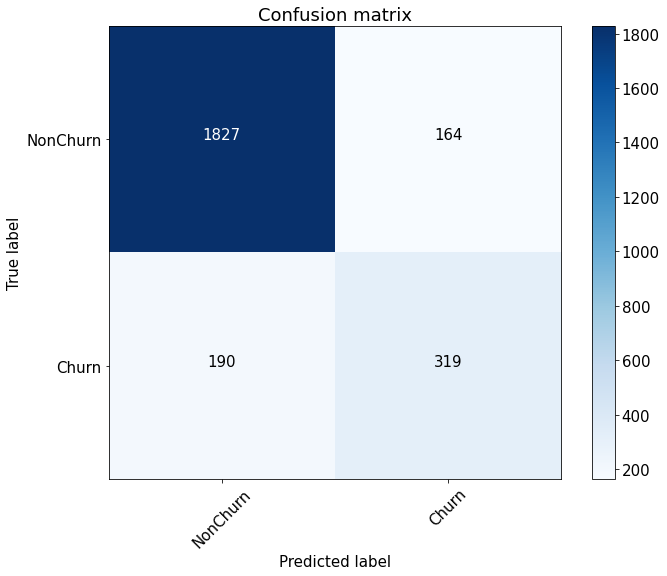

In [50]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_CB>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [51]:
metrics_df = pd.DataFrame(columns=['model', 'threshold', 'f-score', 'precision', 'recall', 'roc_auc'])
metrics_df

,model,threshold,f-score,precision,recall,roc_auc


In [52]:
metrics_df = metrics_df.append({
    'model': type(pipeline_CB['classifier_CB']).__name__,
    'threshold': thresholds[ix],
    'f-score': fscore[ix],
    'precision': precision[ix],
    'recall': recall[ix],
    'roc_auc': roc_auc_CB 
}, ignore_index=True)

In [53]:
metrics_df

,model,threshold,f-score,precision,recall,roc_auc
0,CatBoostClassifier,0.384476,0.644512,0.661157,0.628684,0.876613


**Logistic Regression**

In [54]:
pipeline_LR = Pipeline([
    ('features',feats),
    ('classifier_LR', LogisticRegression(random_state = 42)),
])

In [55]:
#обучим наш пайплайн
pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [56]:
#наши прогнозы для тестовой выборки
preds_LR = pipeline_LR.predict_proba(X_test)[:, 1]
preds_LR[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [57]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_LR)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


In [58]:
roc_auc_LR = roc_auc_score(y_test, pipeline_LR.predict_proba(X_test)[:, 1])

print(f"roc auc score: {roc_auc_score(y_train, pipeline_LR.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_LR}")

roc auc score: 0.7658008314542909
roc auc score: 0.7720774921330664


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


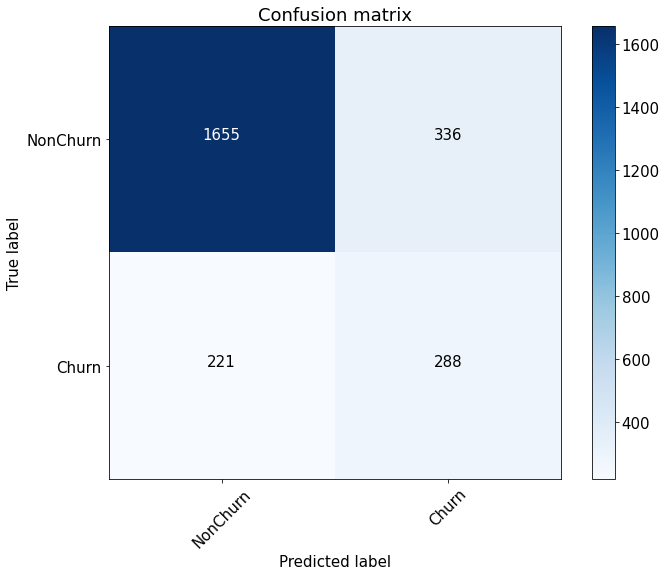

In [59]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_LR = confusion_matrix(y_test, preds_LR>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_LR, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [60]:
metrics_df = metrics_df.append({
    'model': type(pipeline_LR['classifier_LR']).__name__,
    'threshold': thresholds[ix],
    'f-score': fscore[ix],
    'precision': precision[ix],
    'recall': recall[ix],
    'roc_auc': roc_auc_LR
}, ignore_index=True)

metrics_df

,model,threshold,f-score,precision,recall,roc_auc
0,CatBoostClassifier,0.384476,0.644512,0.661157,0.628684,0.876613
1,LogisticRegression,0.289522,0.509700,0.462400,0.567780,0.772077


2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

**Выводы**

Лучшей моделью исходя из таблицы является модель Catboost.
Наиболее важные метрики f_score и precision - так как мы не хотим напрявлять усилия по предотвращению оттока и тратить деньги, только на людей, кто действительно собирался в отток. 

Confusion matrix, without normalization
[[1827  164]
 [ 189  320]]


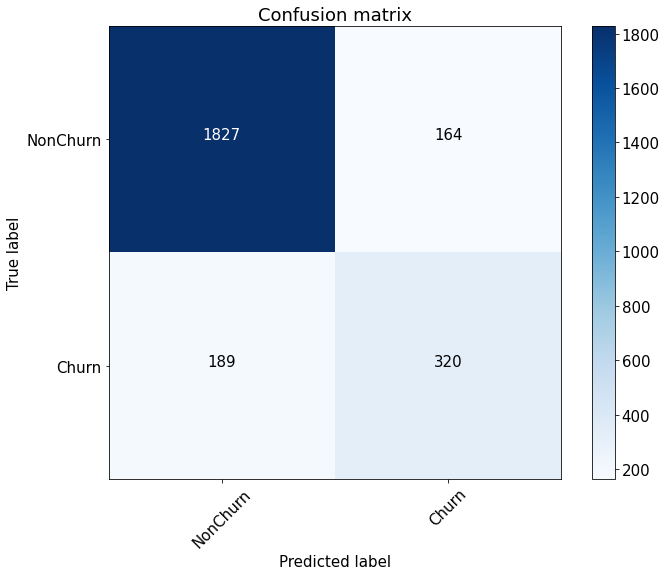

In [62]:
#1 доллар на привлечение 
#2 долллара с каждого True positive

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_CB>0.384476	)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [66]:
TP = cnf_matrix[1, 1]
FP = cnf_matrix[0, 1]
TN = cnf_matrix[0, 0]
FN = cnf_matrix[1, 0]
TP, FP, TN, FN

(320, 164, 1827, 189)

In [70]:
costs_CB = (TP * 2) - (TP + FP) * 1
costs_CB

156

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


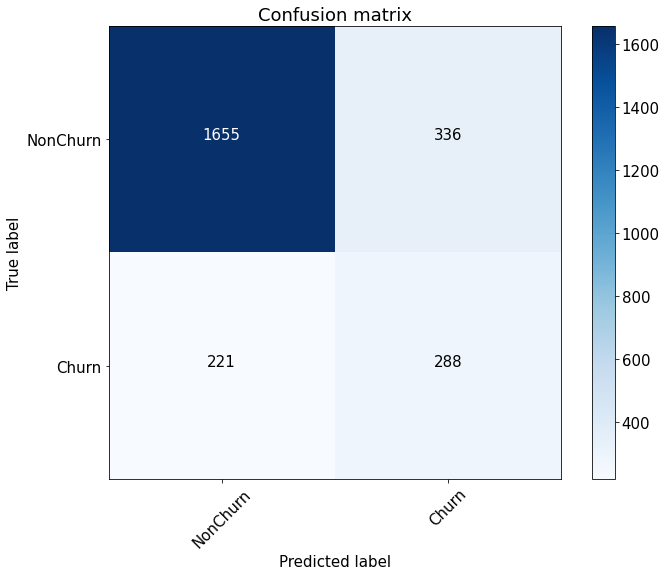

In [71]:
#найдем показатели с логистической регрессией

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_LR = confusion_matrix(y_test, preds_LR>0.289522)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_LR, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [75]:
TN = cnf_matrix_LR[0][0]
FP = cnf_matrix_LR[0][1]
FN = cnf_matrix_LR[1][0]
TP = cnf_matrix_LR[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

result = income - retain_sum

result

-48

In [76]:
metrics_df['business_result'] = [costs_CB, result]
metrics_df

,model,threshold,f-score,precision,recall,roc_auc,business_result
0,CatBoostClassifier,0.384476,0.644512,0.661157,0.628684,0.876613,156
1,LogisticRegression,0.289522,0.509700,0.462400,0.567780,0.772077,-48
